In [1]:
%matplotlib inline

# MALDI-TOF
This data set was genereated as a simplex mixture design of cow milk, goat milk and ewe milk. There are 45 different mixtures in the training data. The design was reused for the test data, using a different random seed for the order of the experimental setup and new milk samples.  
  
The samples where mixed with a liquid matrix and deposited on 4 spots each on a sampling plate resulting in dry films. These were measured using a Matrix Assisted Laser Desorption/Ionization - Time of Flight instrument, which estimates atomic weight in Daltons by measuring relative counts of molecules (peptides/proteins) having mass-to-charge ratios (m/z) ranging from 5kDa to 100kDa. Molecules of m/z > 20kDa have been removed. See Liland et al. 2009 for details (https://dx.doi.org/10.1016/j.chemolab.2009.07.008).  
  
Since measurements of sets of 4 spots come from the same milk mixture, it is natural to average predictions over the spot replicates before computing $R^2$-prediction scores.

## Preparation and visualization of data
Import data and select cow milk concentration as response, disregarding goat and ewe.

In [2]:
from scipy.io import loadmat
import numpy as np

# Load data set
matfile = loadmat('maldi_groups.mat')

# Training data
X_train_raw = matfile['spectra']
y_train     = matfile['y_ex'][:,:1]

# Test data
X_test_raw = matfile['spectra_rep']
y_test     = matfile['y_rep_ex'][:,:1]

X_train_raw.shape

(180, 6179)

### Plot of raw data
The MALDI-TOF data has previously been square-root transformed and baseline corrected. High mass protein measurements have been removed (> 20kDa).

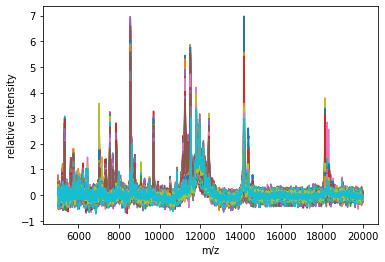

In [3]:
import matplotlib.pyplot as plt
# Extract abcissa
mz = matfile['mz'].T

# Plot with garnish
plt.plot(mz, X_train_raw.T)
plt.xlabel('m/z')
plt.ylabel('relative intensity')
plt.title('')
plt.show()

## Data preparation
Import groups for group-lasso and remove m/z areas with minimal peptide/protein signatures.

In [4]:
# Integer groups for the group-lasso, -1 for exclude
groups_raw = matfile['groups'][0,:]
X_train    = X_train_raw[:, groups_raw != -1]
X_test     = X_test_raw[:, groups_raw != -1]
mz_gr      = mz[groups_raw != -1]
groups     = groups_raw[groups_raw != -1]
print(X_train.shape)
print(X_test.shape)
print(groups.shape)

(180, 708)
(180, 708)
(708,)


### Visualization of the groups
99 small and large peaks and distinct peak shoulders have been defined as groups based on visual inspection of a set of spectra.

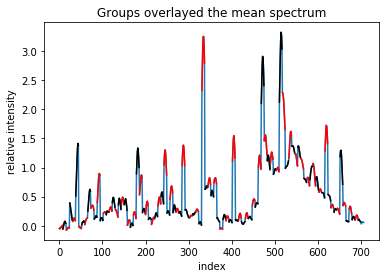

In [5]:
x      = np.arange(len(groups))
mean_X = np.mean(X_train, axis=0)
plt.plot(mean_X)
for i in range(np.max(groups)):
    if i%2 == 0:
        plt.plot(x[groups==i], mean_X[groups==i], '-k')
    else:
        plt.plot(x[groups==i], mean_X[groups==i], '-r')
plt.title('Groups overlayed the mean spectrum')
plt.xlabel('index')
plt.ylabel('relative intensity')
plt.show()

## Fit group-lasso model
- A range of group regularisation parameter values are fit.
- A Ridge reggression model is fit to the transformed data.
- Test data are transformed and predicted.

In [6]:
from group_lasso import GroupLasso
from sklearn.linear_model import Ridge

# GroupLasso and Ridge
gl = GroupLasso(
    groups=groups,
    n_iter=100,
    tol=1e-8,
    l1_reg=0,
    group_reg=1,
    fit_intercept=True,
    warm_start=True,
    supress_warning=True,
    random_state=42)

rr = Ridge(alpha=10**-6)
group_sel = []
preds = []
reg_vals = np.linspace(0.005,0.03,11)

for i, g_reg in enumerate(reg_vals):
    gl.set_params(group_reg=g_reg)
    gl.fit(X_train, y_train)
    rr.fit(gl.transform(X_train), y_train)
    preds.append( rr.predict(gl.transform(X_test)) )
    group_sel.append( np.unique(gl.groups[gl.sparsity_mask_]) )

C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not conv

### Compute mean predictions per replicate set

In [7]:
cv_rep = matfile['cv_rep'][:,0]
R2_pred = []
for pred in preds:
    R2_pred.append(np.corrcoef(np.bincount(cv_rep, weights=pred[:,0]), np.bincount(cv_rep, weights=y_test[:,0]))[0,1]**2)

### Extract unique group selections

In [8]:
uniques = np.fliplr(np.unique([len(i) for i in group_sel], return_index=True))[1]
group_sel_unique = [group_sel[i] for i in uniques]
R2_pred_unique   = [R2_pred[i] for i in uniques]
preds_unique     = [preds[i] for i in uniques]
reg_vals_unique  = [reg_vals[i] for i in uniques]

### Prediction plot

In [9]:
from ipywidgets import interactive
def f(group):
    plt.figure(0)
    ymin = np.min([y_test,preds_unique[group]])
    ymax = np.max([y_test,preds_unique[group]])
    plt.plot(y_test,preds_unique[group],'ok')
    plt.plot([ymin,ymax],[ymin,ymax], '--r')
    plt.title('Groups selected: {0}, R2pred: {1}, Group reg.: {2}'.format(
        len(group_sel_unique[group]), np.round(R2_pred_unique[group],3), 
        np.round(reg_vals_unique[group],4)))
    plt.xlabel('reference')
    plt.ylabel('predicted')
    plt.show()

interactive_plot = interactive(f, group=(0, len(uniques)-1, 1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=3, description='group', max=6), Output(layout=Layout(height='300px'))), …

### Illustrate included groups and R2pred

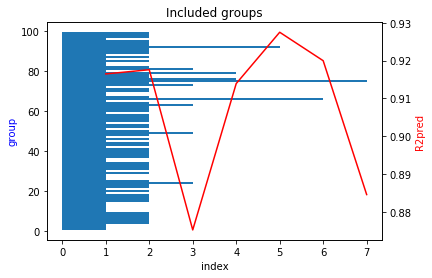

In [10]:
heights = np.zeros([99])
for i, gr in enumerate(group_sel_unique):
    for j in gr:
       heights[j-1] = i+1

fig, ax1 = plt.subplots()
ax1.barh(np.arange(1,100), heights)
ax2 = ax1.twinx()
ax2.plot(np.arange(len(R2_pred_unique))+1,R2_pred_unique,'-r')
ax1.set_xlabel('index')
ax1.set_ylabel('group', color='b')
ax2.set_ylabel('R2pred', color='r')
plt.title('Included groups')
plt.show()

#### Groups corresponding to maximum explained variance

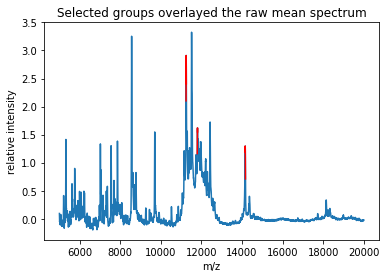

In [15]:
sels = group_sel_unique[np.argmax(R2_pred_unique)]
mean_X_raw = np.mean(X_train_raw, axis = 0)
plt.plot(mz, mean_X_raw)
for i in range(len(sels)):
    plt.plot(mz[groups_raw==sels[i]], mean_X_raw[groups_raw==sels[i]], '-r')
plt.title('Selected groups overlayed the raw mean spectrum')
plt.xlabel('m/z')
plt.ylabel('relative intensity')
plt.show()

.  
.  
TODO: Include time consuming cross-validation?  
.  
.  

In [18]:
from sklearn.pipeline        import make_pipeline
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

# GroupLasso and Ridge pipeline
gl_pipe = make_pipeline(
    GroupLasso(
        groups=groups,
        n_iter=100,
        tol=1e-8,
        l1_reg=0,
        group_reg=1,
        fit_intercept=True,
        warm_start=True,
        supress_warning=True),
    Ridge(alpha=10**-6))

cv  = matfile['cv']
gkf = GroupKFold(n_splits=5)
gkf_seg = gkf.split(X_train, groups=cv)
l1_grid = [{'grouplasso__group_reg': np.linspace(0,0.05,11)}]

gs = GridSearchCV(estimator=gl_pipe, 
                  param_grid=l1_grid, 
                  scoring='r2', 
                  cv=gkf_seg,
                  n_jobs=1)
gs = gs.fit(X_train, y_train)

C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not conv

C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,
C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not conv

In [19]:
gs.cv_results_['mean_test_score']

array([0.94111484, 0.94111484, 0.94111484, 0.94111484, 0.94103115,
       0.93906182, 0.93792863, 0.92662001, 0.86666281, 0.78566084,
       0.77063815])

Under så visualiseres group lasso koeffisientene. Dette er ikke koefisientene vi bruker for å regne ut R2 så et er kanskje litt missvisende, men det gjør det lett å se faseskiftet når vi øker regulariseringsparameteren.

<IPython.core.display.Javascript object>


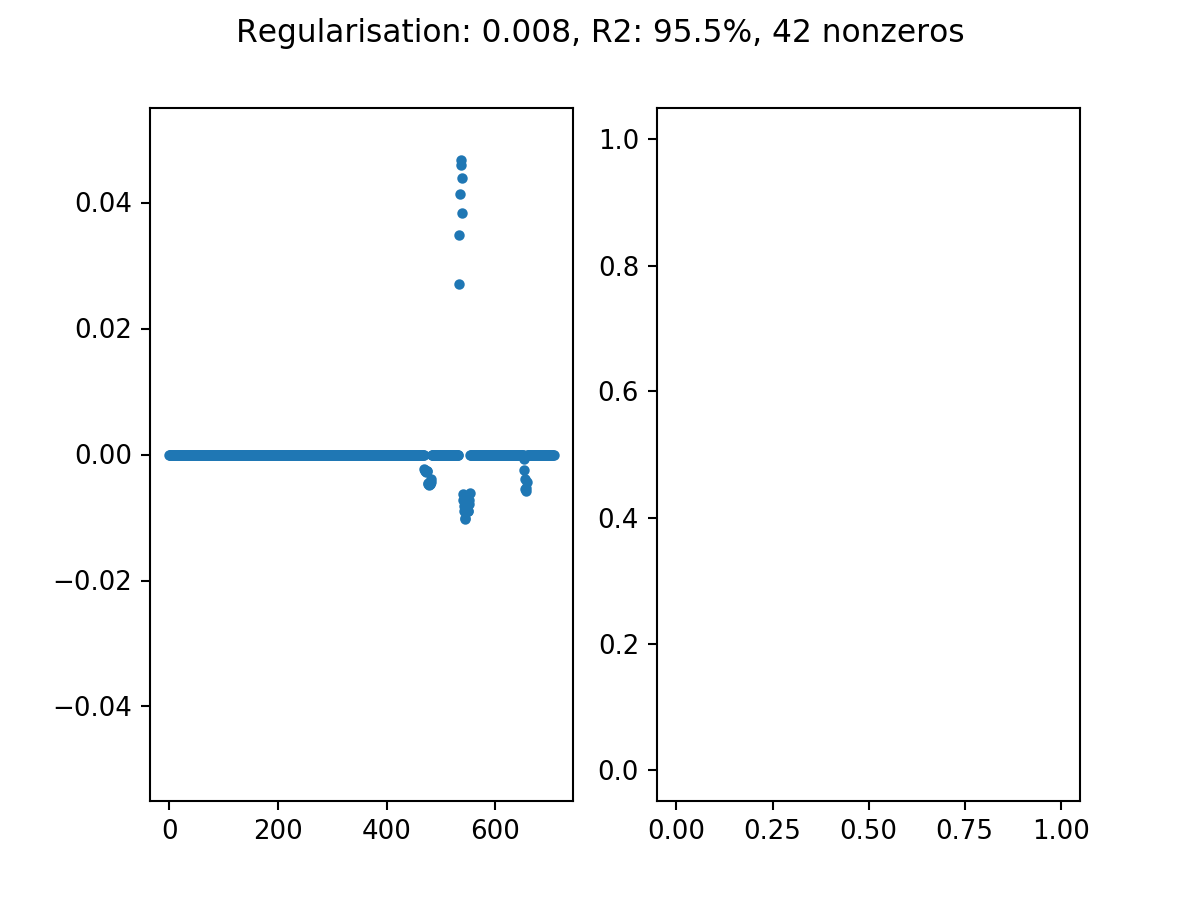

C:\NMBU\Miniconda3\envs\tf2\lib\site-packages\group_lasso\_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,


interactive(children=(FloatSlider(value=0.05, description='reg', max=0.1, min=0.001, step=0.001), Output()), _…

In [20]:
fig, (coef_ax, loss_ax) = plt.subplots(1,2)
gl = GroupLasso(
    groups=groups,
    n_iter=100,
    tol=1e-8,
    l1_reg=0,
    group_reg=1,
    fit_intercept=True,
    warm_start=True,
    supress_warning=True
)
gl.fit(X_train, y_train)

coef_plot = coef_ax.plot(gl.coef_, '.')[0]
loss_plot = loss_ax.plot(gl.losses_, '.')[0]

linear_model = Ridge(alpha=0)

@interact(reg=(0.001, .1, 0.001))
def replot(reg):
    gl.group_reg = reg
    gl.fit(X_train, y_train)
    
    linear_model.fit(gl.transform(X_train), y_train)
    yhat = linear_model.predict(gl.transform(X_train))
    
    loss_plot.set_ydata(gl.losses_)
    coef_plot.set_ydata(gl.coef_)
    fig.suptitle(f"Regularisation: {reg}, R2: {r2_score(y_train, yhat):.1%}, {np.sum(gl.sparsity_mask)} nonzeros")
    print(f"The chosen groups are {np.unique(gl.groups[gl.sparsity_mask])}")